In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = 'Alex-L1'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:01<00:00, 10.06it/s]


Epoch: 1 	Training Loss: 0.143590 	Val Loss: 0.090796	     in time 2.081097m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 2 	Training Loss: 0.073394 	Val Loss: 0.063674	     in time 2.174036m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.60it/s]


Epoch: 3 	Training Loss: 0.057704 	Val Loss: 0.054044	     in time 2.178552m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.60it/s]


Epoch: 4 	Training Loss: 0.052168 	Val Loss: 0.050751	     in time 2.183212m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 5 	Training Loss: 0.049814 	Val Loss: 0.048903	     in time 2.186134m


 48%|███████████████████████████████████████████████▏                                                   | 581/1219 [01:01<01:05,  9.71it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.57it/s]


Epoch: 8 	Training Loss: 0.045899 	Val Loss: 0.045312	     in time 2.187393m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 9 	Training Loss: 0.044717 	Val Loss: 0.044594	     in time 2.184561m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.57it/s]


Epoch: 10 	Training Loss: 0.043990 	Val Loss: 0.043918	     in time 2.185961m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.58it/s]


Epoch: 11 	Training Loss: 0.043506 	Val Loss: 0.043557	     in time 2.183203m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 12 	Training Loss: 0.043126 	Val Loss: 0.043211	     in time 2.186894m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 13 	Training Loss: 0.042808 	Val Loss: 0.043055	     in time 2.183836m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.60it/s]


Epoch: 14 	Training Loss: 0.042507 	Val Loss: 0.042975	     in time 2.180254m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.57it/s]


Epoch: 15 	Training Loss: 0.042221 	Val Loss: 0.042639	     in time 2.186199m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.57it/s]


Epoch: 16 	Training Loss: 0.042025 	Val Loss: 0.042324	     in time 2.187165m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.53it/s]


Epoch: 17 	Training Loss: 0.041807 	Val Loss: 0.042132	     in time 2.197487m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:10<00:00,  9.35it/s]


Epoch: 18 	Training Loss: 0.041586 	Val Loss: 0.041972	     in time 2.245799m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:12<00:00,  9.22it/s]


Epoch: 19 	Training Loss: 0.041405 	Val Loss: 0.041727	     in time 2.274394m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:12<00:00,  9.19it/s]


Epoch: 20 	Training Loss: 0.041147 	Val Loss: 0.042371	     in time 2.284863m
CPU times: user 37min 10s, sys: 11min 26s, total: 48min 37s
Wall time: 43min 50s


# Results

In [11]:
def show(img, ax = None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
path = Path("results") / RUN_NAME

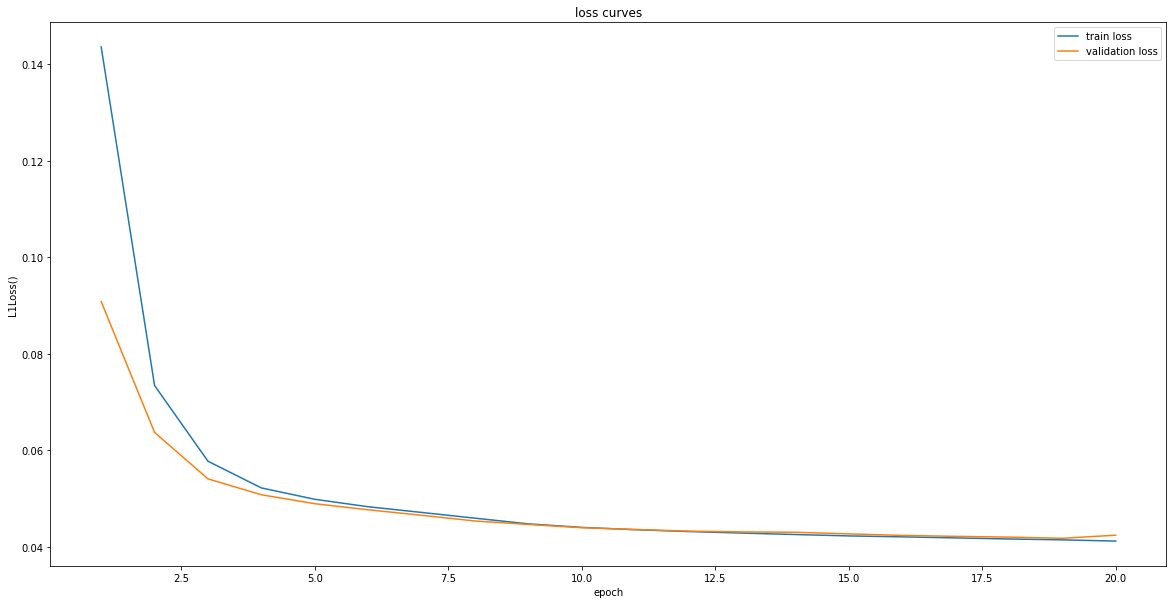

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(train_losses.keys(), train_losses.values(), label="train loss")
plt.plot(val_losses.keys(), val_losses.values(), label="validation loss")
plt.title("loss curves")
plt.legend()
plt.xlabel("epoch")
plt.ylabel(str(criterion))
plt.savefig(path / "loss_curves.png")

In [13]:
with open(path / "loss_values.txt", "w") as f:
    for i in train_losses.keys():
        f.write(f"epoch {i}: train loss is {train_losses[i]:.6f}, validation loss is {val_losses[i]:.6f}\n")

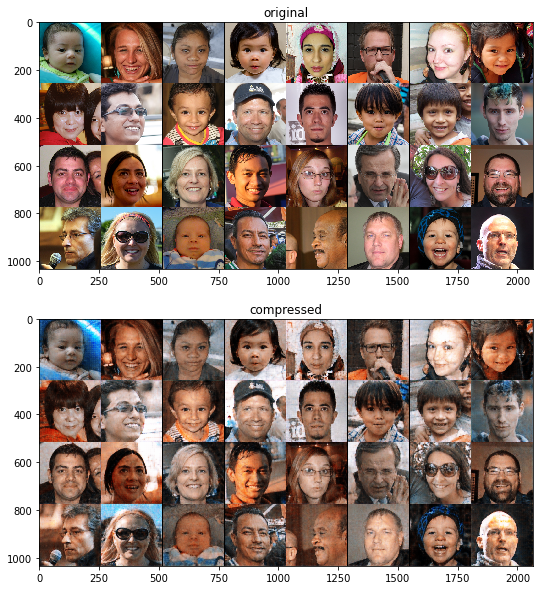

In [14]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()

fig, axes = plt.subplots(2, figsize=(20, 10))
show(make_grid(images), axes[0])
axes[0].set_title("original")
show(make_grid(outputs), axes[1])
axes[1].set_title("compressed")
plt.savefig( path / 'validation_compare.png')